# Connectivity analysis

* **Description**: Open data file and explore LSs
* **Status**: Active
* **Succeeded by**:
* **See also**: 040

In [31]:
import uproot
import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import awkward as ak

import matplotlib.pyplot as plt
import scienceplots

from collections import defaultdict
import torch
from gnn_tracking.analysis.graphs import (
    get_track_graph_info_from_data,
    get_largest_segment_fracs,
    get_all_graph_construction_stats,
)

plt.style.use(["science", "notebook"])

## Configure

In [32]:
rpath = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/lst_data_v1/root/tuple.root"
)
assert rpath.is_file()
dpath = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/lst_data_v1/processed"
)
assert dpath.is_dir()

In [33]:
tree = uproot.open(rpath)["tree"]

In [34]:
ETA_THLD = 3

## Number of hits per PID

In [35]:
# Counting the number of hits per particle ID
s = []
for i in tqdm(range(100)):
    pid = tree["MD_sim_idx"].array()[i].to_numpy()
    pt = tree["MD_sim_pt"].array()[i].to_numpy()
    eta = tree["MD_sim_eta"].array()[i].to_numpy()
    s.extend(
        pd.Series(pid[(pt > 0.9) & (np.abs(eta) < ETA_THLD)]).value_counts().to_list()
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Text(0.5, 0, 'Number of hits ($p_T > 0.9$ GeV, $|\\eta| < 3$)')

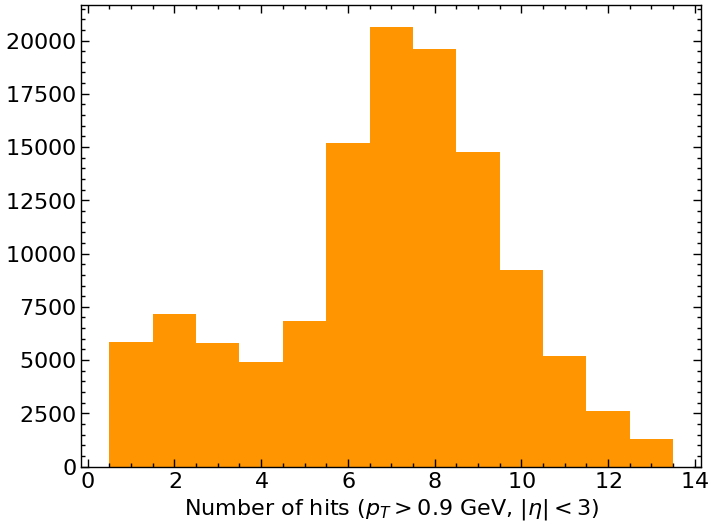

In [39]:
plt.hist(s, bins=np.arange(1, 15) - 0.5, color="C2")
plt.xlabel(rf"Number of hits ($p_T > 0.9$ GeV, $|\eta| < {ETA_THLD}$)")

## Default accuracy CC

## Various stats

**Todo**: Eta cut

In [37]:
def get_ls_purities(path: Path, *, n_files=100) -> np.ndarray:
    purities = []
    for f in tqdm(list(path.glob("*.pt"))[:n_files]):
        data = torch.load(f)
        data.y = data.y.long()
        mask = (
            (data.pt[data.edge_index[0]] > 0.9)
            & data.reconstructable[data.edge_index[0]]
            & (data.eta[data.edge_index[0]] < ETA_THLD)
        )
        purities.append((data.y[mask].sum() / mask.sum()).item())
    return np.array(purities)


purities = get_ls_purities(dpath)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.33it/s]


Text(0.5, 0, 'LS Purity ($p_T > 0.9$ GeV, $|\\eta| < 3$)')

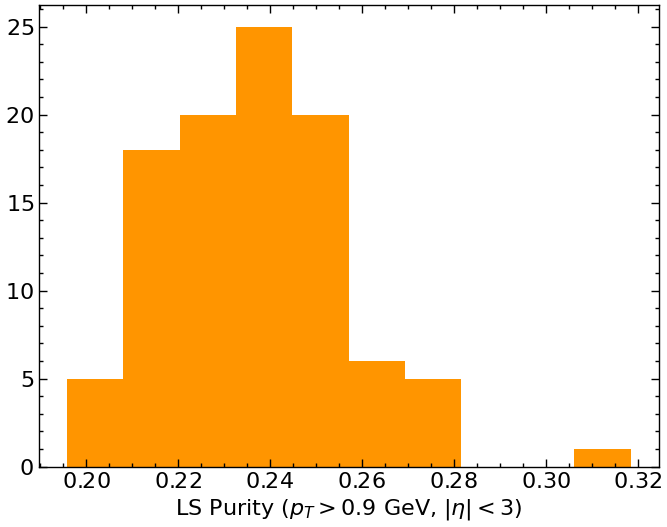

In [44]:
plt.hist(purities, color="C2")
plt.xlabel(
    rf"LS Purity ($p_T > 0.9$ GeV, $|\eta| < {ETA_THLD}$)",
)

In [41]:
def get_gc_stats(path: Path, *, n_files=10):
    records = list[dict[str, float]]()
    for f in tqdm(list(path.glob("*.pt"))[:n_files]):
        data = torch.load(f)
        records.append(get_all_graph_construction_stats(data))
    return pd.DataFrame.from_records(records)

In [42]:
gc_stat_df = get_gc_stats(dpath)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.13s/it]


In [43]:
gc_stat_df

,n_orphan_correct,n_orphan_incorrect,n_orphan_total,frac_segment100,frac_component100,frac_segment50,frac_component50,frac_segment75,frac_component75,n_segments,frac_hits_largest_segment,frac_hits_largest_component,n_hits,n_hits_noise,n_hits_thld,n_edges,n_tracks,n_true_edges,n_true_edges_thld
0,0,0,0,0.187097,0.325806,0.845161,0.935484,0.478495,0.626882,2.898925,0.704058,0.787910,31269,13820,6413,91168,5310,8138,tensor(15486)
1,0,0,0,0.149321,0.302413,0.858220,0.942685,0.446456,0.625943,3.046757,0.691527,0.783974,41574,16694,9328,148165,7089,11519,tensor(29212)
2,0,0,0,0.148805,0.329221,0.830378,0.932151,0.443331,0.621434,3.144950,0.682884,0.788057,40277,16770,9155,142496,6766,11105,tensor(29059)
3,0,0,0,0.164542,0.315180,0.871379,0.940904,0.461182,0.610660,2.938586,0.703341,0.784516,30538,14795,6006,96920,4674,7553,tensor(16958)
4,0,0,0,0.157105,0.315093,0.844660,0.937335,0.457193,0.619594,2.996470,0.693501,0.786527,37018,15648,7915,118061,6111,10219,tensor(21856)
5,0,0,0,0.180974,0.331787,0.819799,0.916473,0.459397,0.617943,3.074246,0.692345,0.782907,37860,14771,9103,125418,6616,10980,tensor(27626)
6,0,0,0,0.162031,0.315716,0.815021,0.927677,0.436022,0.606398,3.126565,0.680911,0.779648,44954,17294,10000,165241,8179,12216,tensor(33571)
7,0,0,0,0.169553,0.316317,0.831358,0.919781,0.458523,0.610757,3.122151,0.693344,0.779928,33512,13728,7938,107894,5588,9710,tensor(22300)
8,0,0,0,0.161218,0.331352,0.831352,0.939822,0.427935,0.618128,3.137444,0.684520,0.787475,45309,17578,9539,172349,7967,12029,tensor(33704)
9,0,0,0,0.181511,0.323563,0.857948,0.931229,0.462232,0.611048,2.923337,0.702970,0.784804,30925,14456,6087,94535,4903,7638,tensor(15809)


## LSF vs eta

In [14]:
# fixme: Double check that pt threshold is correctly applied
dpath = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/lst_data_v1/processed"
)
fracs = defaultdict(list)
etas = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
for f in tqdm(list(dpath.glob("*.pt"))[:10], total=10):
    data = torch.load(f)
    data.y = data.y.long()
    for eta in etas:
        # this is stupid, we should just take the pids and merge on the
        # etas, but we can't do that right now
        fracs[eta].extend(
            get_largest_segment_fracs(
                data=data,
                pt_thld=0.9,
                max_eta=eta,
            ).tolist()
        )

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.77it/s]


(array([4870., 4243., 4597., 4125., 1404.,   45.,   13.,   17.,    5.,
           8.]),
 array([2.62407430e-05, 5.39658904e-01, 1.07929158e+00, 1.61892414e+00,
        2.15855694e+00, 2.69818950e+00, 3.23782206e+00, 3.77745485e+00,
        4.31708765e+00, 4.85671997e+00, 5.39635277e+00]),
 <BarContainer object of 10 artists>)

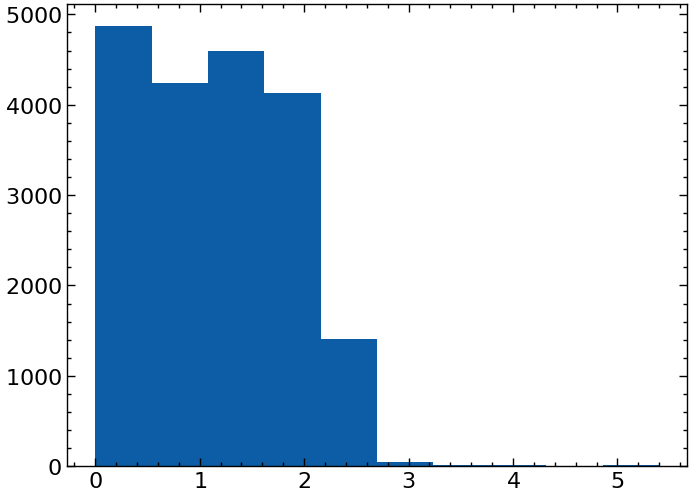

In [15]:
plt.hist(data.eta.abs()[data.eta.abs() < 10])

In [16]:
df = pd.DataFrame(index=etas)
df["eta"] = df.index
dfracs = {eta: np.array(fs) for eta, fs in fracs.items()}
df["frac25"] = [(dfracs[eta] > 0.25).mean() for eta in etas]
df["frac50"] = [(dfracs[eta] > 0.48).mean() for eta in etas]
df["frac100"] = [(dfracs[eta] > 0.99).mean() for eta in etas]

Text(0.5, 0, '$\\eta$ cut')

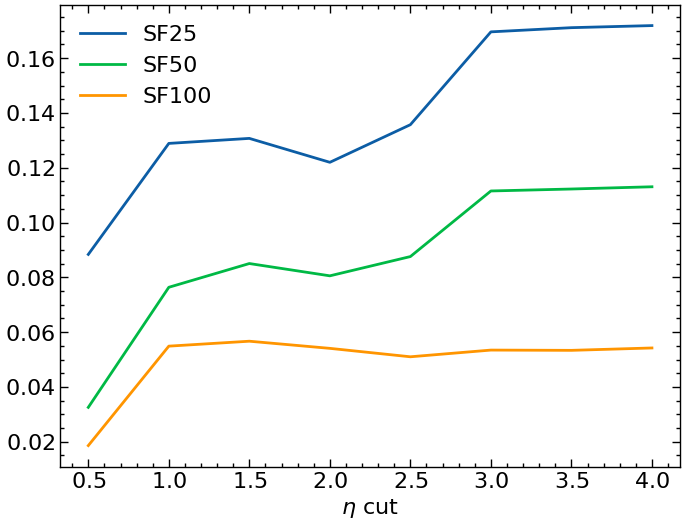

In [17]:
fig, ax = plt.subplots()
ax.plot("eta", "frac25", data=df, label="SF25")
ax.plot("eta", "frac50", data=df, label="SF50")
ax.plot("eta", "frac100", data=df, label="SF100")
ax.legend()
ax.set_xlabel("$\eta$ cut")